<a href="https://colab.research.google.com/github/musicangora/DCGAN_Xray/blob/master/DCGAN_Xray_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 参考
- [胸部X線画像を対象とした敵対的生成ネットワーク - DCGAN -](https://qiita.com/tatsunidas/items/779ebe6e403b9b3e85f7)
- [画像の前処理](https://keras.io/ja/preprocessing/image/)
- [Keras - Keras の ImageDataGenerator を使って学習画像を増やす](https://www.pynote.info/entry/keras-image-data-generator#%E5%90%84%E7%94%BB%E7%B4%A0%E5%80%A4%E3%81%AB%E5%80%A4%E3%82%92%E8%B6%B3%E3%81%99)

### トレーニング画像
- [MINIJSRT_DATABASE](http://imgcom.jsrt.or.jp/minijsrtdb/)

In [1]:
'''
Google Driveをマウント
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
'''
パラメータの設定
'''
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow import keras

TRAIN_DIR = '/content/drive/My Drive/miniJSRT_databese/'  # 訓練画像のパス
SAVE_DIR = '/content/drive/My Drive/Norandomize/'  # 保存先のパス

batch_size = 16  # 各バッチに含める画像の数
steps_per_epoch = 1000  # トレーニングセットの繰り返しごとに何回のステップを踏むか（バッチ数）
epochs = 10  # トレーニングセットの繰り返すの回数

np.random.seed(10)  # 乱数と画像の整合性のため
noise_dim = 100  # ランダムなベクトルの入力次元、Generatorに入力される

img_rows, img_cols, channels = (32, 32, 1)  # 画像の寸法、色の数であるチャンネル数

optimizer = Adam(0.0002, 0.5)  # 最適化関数の推奨値

In [3]:
'''
データセットの前処理
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ディレクトリから画像を読み込み、イテレータを生成
iters = ImageDataGenerator().flow_from_directory(
    TRAIN_DIR,
    target_size=(32, 32),  # (h, w)：この値に全画像はリサイズされる
    color_mode="grayscale",  # カラーモードをグレースケールに
    class_mode=None,  # "categorical"/"binary"/"sparde"/"input"/"None"のうちどれか
    batch_size=244,  # データのバッチサイズ
    shuffle=True  # データをシャッフルするかどうか
)

# イテレータから1ミニバッチ分のデータを取得
x_train = next(iters)

# ピクセル値が-1から1になるように画像を正規化する
x_train = (x_train.astype(np.float32) - 127.5) / 127.5


print("shape of x_train_batch: ", x_train.shape)

Found 247 images belonging to 1 classes.
shape of x_train_batch:  (244, 32, 32, 1)


In [4]:
'''
画像表示用の関数
'''
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    # 正規化(0 ~ 1)
    generated_images = generated_images * 0.5 + 0.5
    
    plt.figure(figsize=(10, 10))

    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
'''
画像保存用の関数
'''
import matplotlib.pyplot as plt

def save_images(noise, fname):
    generated_images = generator.predict(noise)
    # 正規化(0 ~ 1)
    generated_images = generated_images * 0.5 + 0.5
    
    fig = plt.figure(figsize=(10, 10))

    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    fname = SAVE_DIR + fname
    fig.savefig(fname, tight_layout=True)

In [6]:
'''
ジェネレータの作成
'''
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_generator_cgan():
    generator = Sequential()

    d = 8
    # 正規分布に従って重みを初期化する、平均=0, 標準偏差=0.02
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Reshape((d, d, 256)))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    # -1から1にしているので最終的な活性化関数はtanh
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator



Using TensorFlow backend.


In [7]:
'''
ディスクリミネータの作成
'''
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))  # ドロップアウト層を追加
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator
    

In [8]:
'''
モデルの生成
'''
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
discriminator.summary()
generator = create_generator_cgan()
generator.summary()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim, ))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

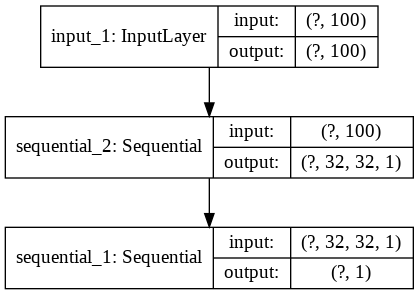

In [9]:
'''
モデルの可視化
'''
import graphviz
import pydot
from tensorflow.keras.utils import plot_model

plot_model(
    generator,
    show_shapes=True,
    to_file='generator.png'
)
plot_model(
    discriminator,
    show_shapes=True,
    to_file='discriminator.png'
)
plot_model(
    gan,
    show_shapes=True,
    to_file='gan.png'
)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1 	 Discriminator Loss: 0.6151382923126221 		 Generator Loss: 0.9229929447174072
now training gan ..., last step is 1
Epoch: 2 	 Discriminator Loss: 0.6380923986434937 		 Generator Loss: 0.9261584877967834
now training gan ..., last step is 2
Epoch: 3 	 Discriminator Loss: 0.5377119183540344 		 Generator Loss: 1.3328157663345337
now training gan ..., last step is 3
Epoch: 4 	 Discriminator Loss: 0.46229493618011475 		 Generator Loss: 1.3149514198303223
now training gan ..., last step is 4
Epoch: 5 	 Discriminator Loss: 0.47404909133911133 		 Generator Loss: 1.5541822910308838
now training gan ..., last step is 5
Epoch: 6 	 Discriminator Loss: 0.39845141768455505 		 Generator Loss: 1.6928842067718506
now training gan ..., last step is 6
Epoch: 7 	 Discriminator Loss: 0.4241088628768921 		 Generator Loss: 2.516796112060547
now training gan ..., last step is 7
Epoch: 8 	 Discriminator Loss: 0.34781986474990845 		 Generator Loss: 3.2212307453155518
now training gan ..., last step is

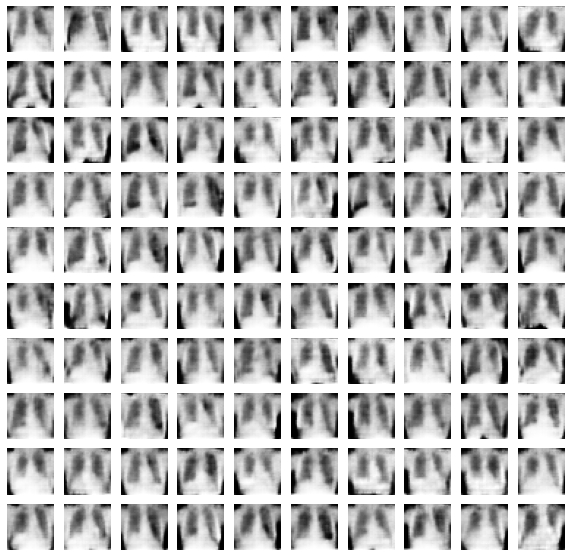

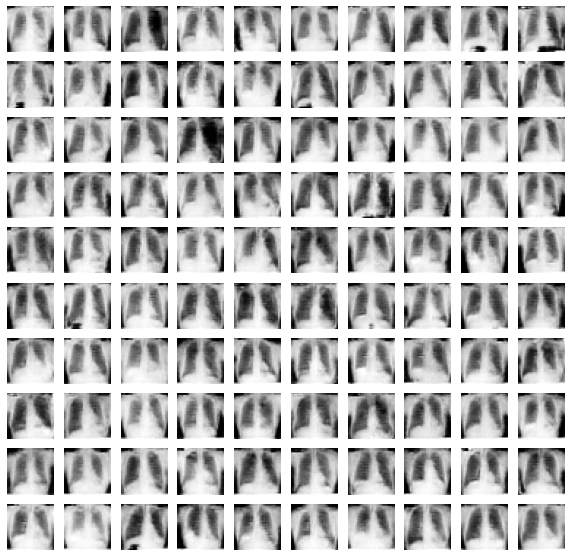

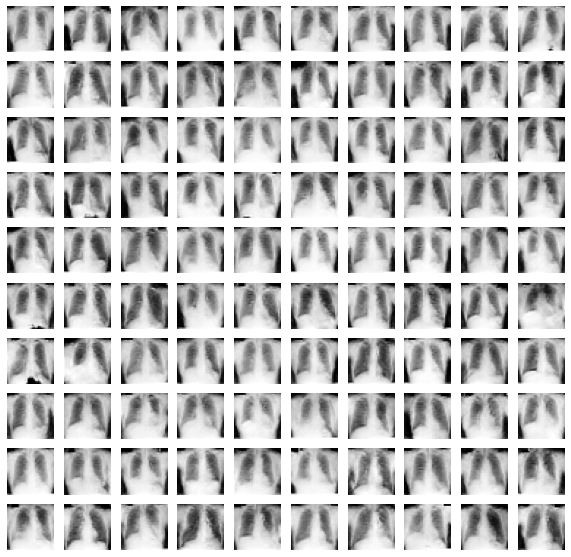

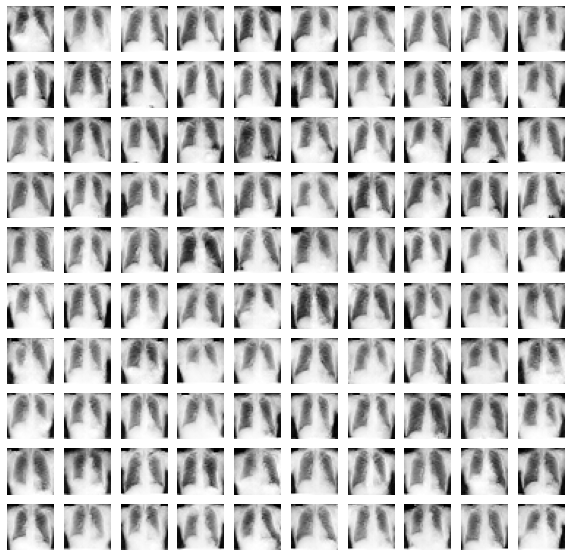

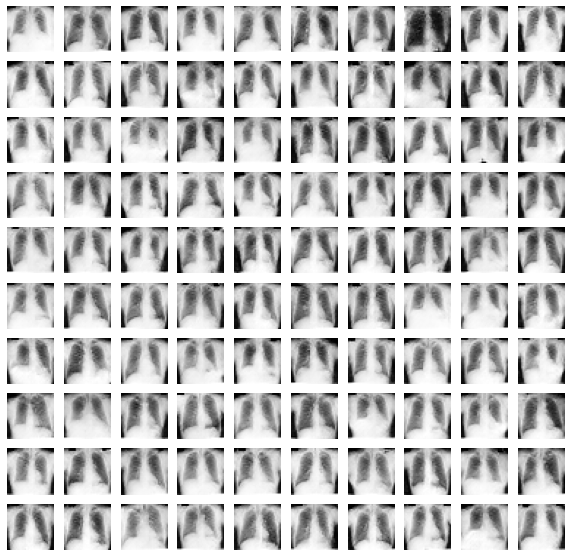

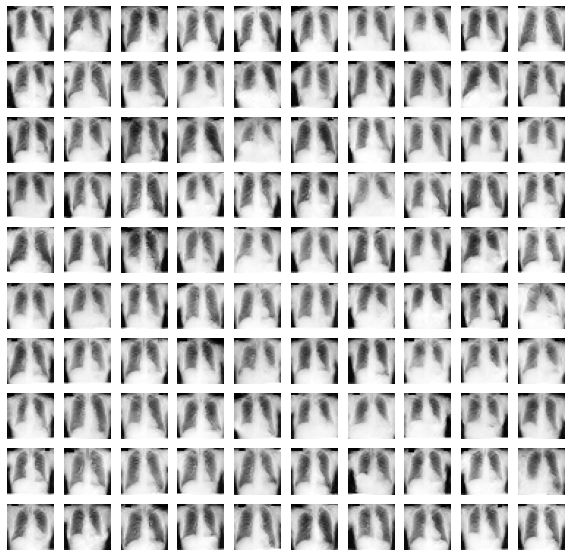

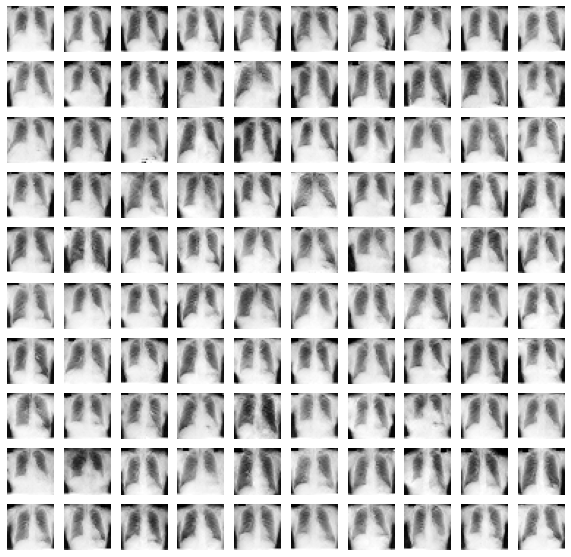

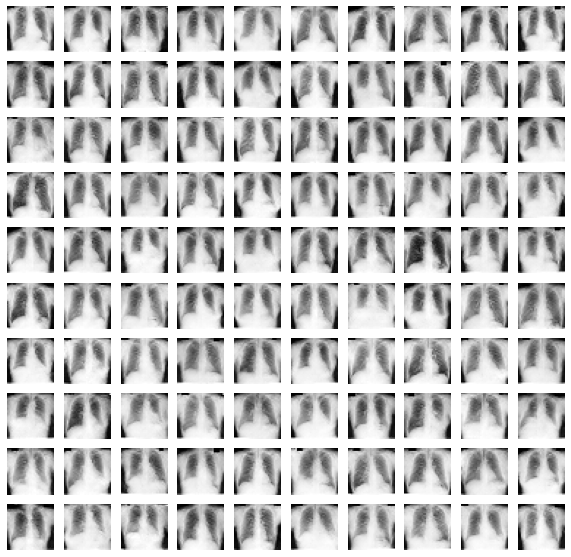

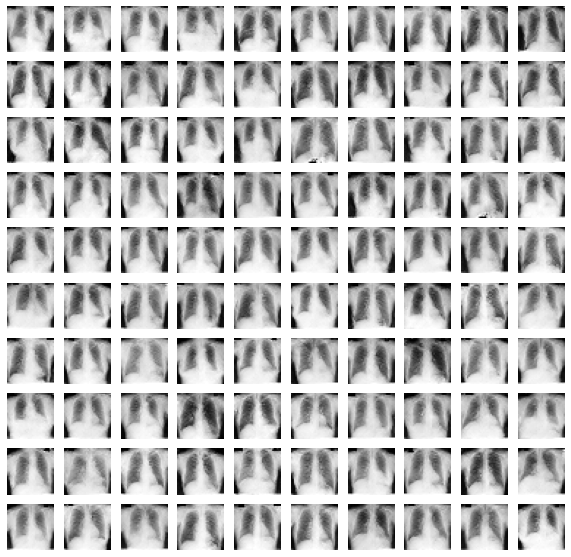

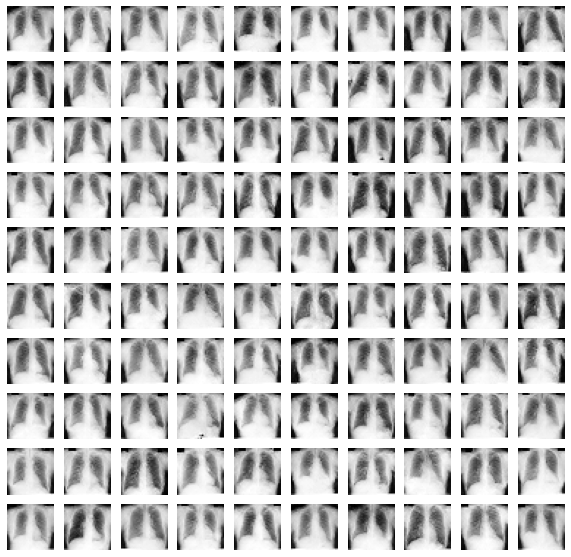

In [10]:
'''
学習
'''
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        # 偽物を作るために無作為にノイズベクトルを作成
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        # ノイズベクトルを画像に変換
        fake_x = generator.predict(noise)

        # 本物画像の取得
        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        x = np.concatenate((real_x, fake_x))

        # ラベルを生成
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9
        disc_y += 0.05 * np.random.random(disc_y.shape)  # ラベルにランダムにノイズを追加

        # ディスクリミネータを訓練
        d_loss = discriminator.train_on_batch(x, disc_y)

        # ノイズベクトルを生成
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

        # すべて本物だというラベルを生成
        y_gen = np.ones(batch_size)
        
        # GANのモデルの訓練を通してジェネレータを訓練
        g_loss = gan.train_on_batch(noise, y_gen)

    # 訓練過程でモデルと結果を保存
    gan.save_weights('gan-discloss_%s_advloss%s.h5' %(d_loss, g_loss))
    print(f'Epoch: {epoch+1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(100, noise_dim))
    # show_images(noise)
    fname = 'Epoch' + str(epoch)
    save_images(noise, fname)
    if epoch == epochs-1:
            print('finish trainning')
    else:
            print('now training gan ..., last step is %s'%(epoch+1))

In [11]:
# ラベルを生成
disc_y = np.zeros(2*batch_size)
disc_y[:batch_size] = 0.9
disc_y_rand = np.zeros(2*batch_size)
disc_y_rand[:batch_size] = 0.9
disc_y_rand += 0.05 * np.random.random(disc_y.shape)  # ラベルにランダムにノイズを追加
print(disc_y)
print(disc_y_rand)

[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[9.05603395e-01 9.09348990e-01 9.42072183e-01 9.26661504e-01
 9.00500993e-01 9.40791325e-01 9.09052769e-01 9.04452701e-01
 9.15516237e-01 9.09514582e-01 9.33896318e-01 9.19597260e-01
 9.42359973e-01 9.26519536e-01 9.45607478e-01 9.07423713e-01
 1.30515509e-02 2.74712137e-02 2.43871525e-02 3.02473629e-02
 4.36208607e-02 3.22625271e-02 4.27107095e-02 1.91692417e-02
 8.09447602e-03 8.20711985e-04 3.55454816e-02 4.87134814e-02
 2.59402643e-02 1.23176075e-02 4.05409628e-02 1.44827915e-02]


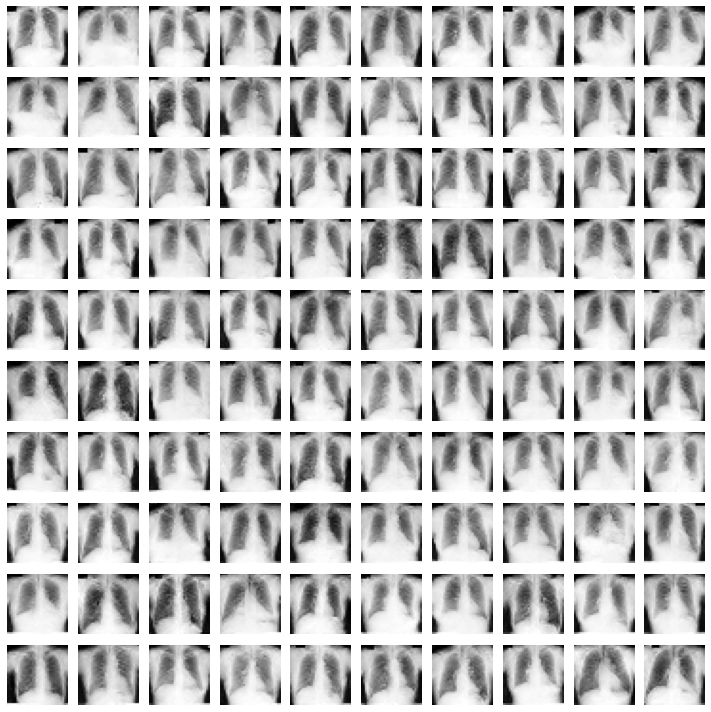

In [12]:
'''
学習後の画像を表示する
'''
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

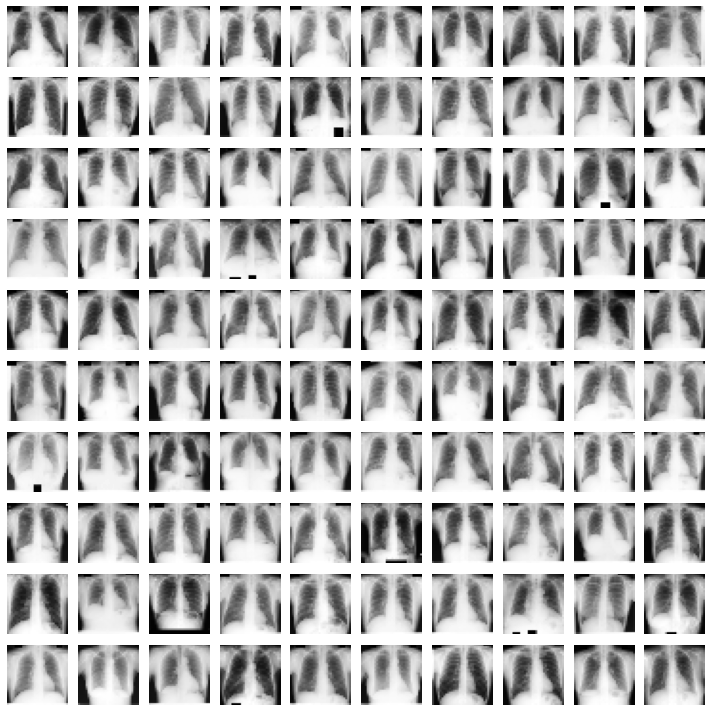

In [13]:
'''
オリジナル画像を表示する
'''
import matplotlib.pyplot as plt
import numpy as np

img = x_train[0:100]
img = (img + 1.0) / 2.0

plt.figure(figsize=(10, 10))

for i, image in enumerate(img):
    plt.subplot(10, 10, i+1)
    plt.imshow(image.reshape(img_cols, img_rows), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
'''
apngモジュールのインストール
'''
!pip install apng

In [15]:
'''
アニメーションの作成
🔗https://qiita.com/kaityo256/items/8ff3219de61433b7be87
'''
from apng import APNG
from PIL import Image, ImageDraw
import IPython 

files = []
frames = epochs
for i in range(frames):
    files.append(SAVE_DIR+'Epoch'+str(i)+'.png')
APNG.from_files(files, delay=800).save(SAVE_DIR+'trainAnimation.png')
IPython.display.Image('trainAnimation.png')